### Question 4: Implementation of PDE methods

#### Choice 1: classic version

##### Part 1: PDE price of European calls

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Step 1: we define a solver class to avoid implementing global variables
class Euro_Call_PDE_Solver:
    def __init__(self, S0, K, T, r, sigma, space_factor = 5, M = 100, N = 100, theta = 0.5):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.M = M
        self.N = N
        self.theta = theta # basic case = 1 for the implicit Euler, choose 1/2 for Crank Nicholson
        self.space_factor = space_factor
        self.L = self.space_factor * np.log(self.K)
        self.dT = self.T / self.M
        self.h = 2 * self.L / self.N
        
        self.t = None
        self.y = None
        self.U = None
        self.price_S0 = None
        self.BS_prices = None
        self.error_tot = None
        self.error = None
        self.log_prices = None
        
    def BS_Euro_Call(self,S,t):
        d1 = (np.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * t) / (self.sigma * np.sqrt(t))
        d2 = d1 - self.sigma * np.sqrt(t)
        return S * stats.norm.cdf(d1) - self.K * np.exp(-self.r * t) * stats.norm.cdf(d2)
    
    
    def TDMA(self,a,b,c,d): #thomas algo, source: https://stackoverflow.com/questions/8733015/tridiagonal-matrix-algorithm-tdma-aka-thomas-algorithm-using-python-with-nump
        
        n = len(d)
        w = np.zeros(n-1,float)
        g = np.zeros(n, float)
        p = np.zeros(n,float)
        
        w[0] = c/b
        g[0] = d[0]/b
    
        for i in range(1,n-1):
            w[i] = c/(b - a*w[i-1])
        for i in range(1,n):
            g[i] = (d[i] - a*g[i-1])/(b - a*w[i-1])
        p[n-1] = g[n-1]
        for i in range(n-1,0,-1):
            p[i-1] = g[i-1] - w[i-1]*p[i]
        return p

    def solve_edp(self):
        y = np.linspace(-self.L, self.L, self.N + 1)  # space discretization
        t = np.linspace(0, self.T, self.M + 1)  # Time discretization

        # Boundary conditions
        U = np.zeros((self.N + 1, self.M + 1)) 
        U[-1, :] = np.maximum(np.exp(y[-1]) - self.K * np.exp(-self.r * t), 0) # and u0,: = 0 already
        U[:, 0] = np.maximum(np.exp(y) - self.K, 0)
        
        # Coefficients of the matrix A
        vol = (self.sigma / self.h)**2 #to simplify notations
        a = 0.5 * vol - (self.r - 0.5 * self.sigma ** 2) / (2 * self.h)
        b = - (vol + self.r)
        c = 0.5 * vol + (self.r - 0.5 * self.sigma ** 2) / (2 * self.h)
        
        # define A
        A = b * np.eye(self.N - 1)
        for i in range(1, self.N-1):
            A[i,i-1] = a
            A[i-1,i] = c
        
        I = np.eye(self.N - 1)
        
        ##recompute the a,b,c for the thomas algo, using the def of the theta method
        a = -self.theta * self.dT * a
        b = 1 - self.theta * self.dT * b
        c = -self.theta * self.dT * c
        transition = I + (1 - self.theta) * self.dT * A
        
        # solving using theta scheme
        for j in range(self.M):
            d = transition @ U[1:-1, j] #solution vector
            U[1:-1 , j+1] = self.TDMA(a,b,c,d)
            
        idx = (np.abs(y - np.log(self.S0))).argmin()
        self.price_S0 = U[idx, -1]
        self.y = y
        self.t = t
        self.U = U
        idx_min = (np.abs(y - np.log(self.S0*0.8))).argmin()
        idx_max = (np.abs(y - np.log(self.S0*1.2))).argmin()       
        self.BS_prices = self.BS_Euro_Call(np.exp(self.y),self.T)
        self.error_tot = np.abs(self.U[:, -1]- self.BS_prices)
        self.error = self.error_tot[idx_min:idx_max]
        self.log_prices = self.U[:, -1][idx_min:idx_max]
        return "Done"

    def plot_results(self):
        y = self.y
        u = self.U
        
        idx_min = (np.abs(y - np.log(self.S0*0.8))).argmin()
        idx_max = (np.abs(y - np.log(self.S0*1.2))).argmin()
        S = np.exp(y)
        Closed_prices = self.BS_Euro_Call(S,self.T)
        PDE_prices = u[:, -1]
        payoff = u[:, 0]

        # Plot the price comparison
        plt.figure()
        plt.plot(S[idx_min:idx_max], PDE_prices[idx_min:idx_max], label="Numerical EDP")
        plt.plot(S[idx_min:idx_max], Closed_prices[idx_min:idx_max], label="Black-Scholes Formula", linestyle="dashed")
        plt.plot(S[idx_min:idx_max], payoff[idx_min:idx_max], label="Payoff")
        
        plt.xlabel("Stock Price S")
        plt.ylabel("Option Price")
        plt.title("European Call Price: Numerical vs Analytical")
        plt.legend()
        plt.grid()
        plt.show()

        # Error analysis
        errors = np.abs(PDE_prices - Closed_prices)
        plt.figure()
        plt.plot(S[idx_min:idx_max], errors[idx_min:idx_max])
        plt.xlabel("S")
        plt.ylabel("Error")
        plt.title("Error Between closed formula and PDE prices")
        plt.grid()
        plt.show()

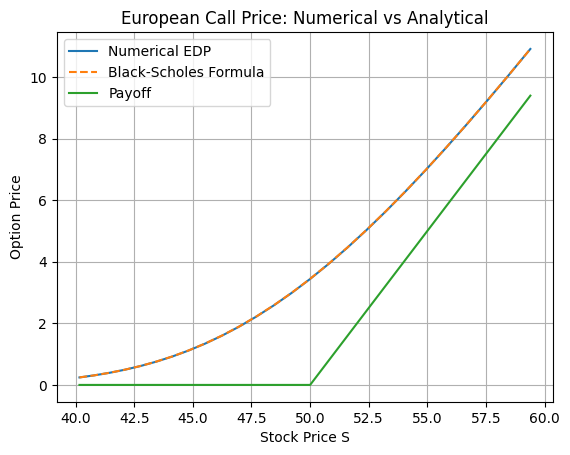

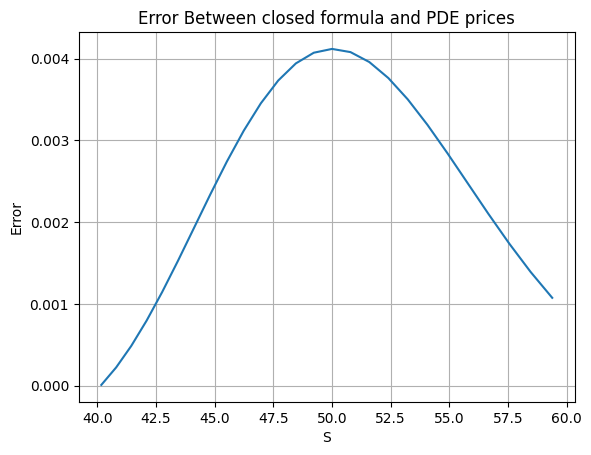

In [4]:
## examples :
solver_CN = Euro_Call_PDE_Solver(S0=50, K=50, T=0.5, r=0.05, sigma=0.2,space_factor=10,M=100,N=5000,theta=0.5)
solver_CN.solve_edp()
solver_CN.plot_results()

#### Part 2 and 3: analysis of the error

500 is done
1000 is done
2000 is done
5000 is done
10000 is done


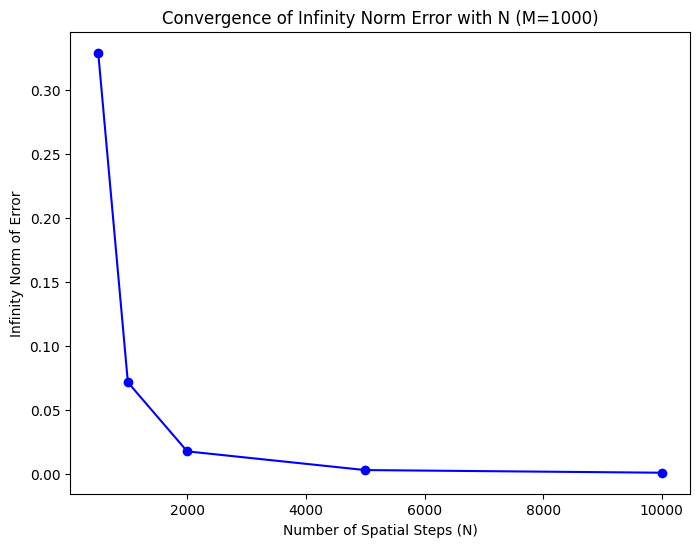

In [122]:
## 1: M fixed, Crank-Nicholson
N=[500,1000,2000,5000,10000]
inf_err = []

for n in N:
    solver_CN = Euro_Call_PDE_Solver(S0=50, K=50, T=1, r=0.05, sigma=0.2,space_factor=10,M=1000,N=n,theta=0.5)
    solver_CN.solve_edp()
    inf_err.append(max(solver_CN.error))
    print(f"{n} is done")
    
# Plot the convergence of the infinity norm error / We used chat gpt here to gain some time and see a better result
plt.figure(figsize=(8, 6))
plt.plot(N, inf_err, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Spatial Steps (N)')
plt.ylabel('Infinity Norm of Error')
plt.title('Convergence of Infinity Norm Error with N (M=1000)')
plt.show()

500 is done
1000 is done
2000 is done
5000 is done
10000 is done


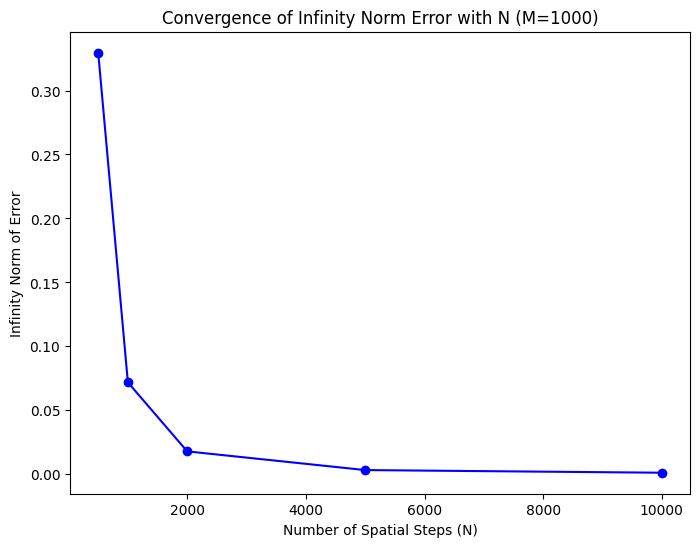

In [123]:
## 1: M fixed, Euler
N=[500,1000,2000,5000,10000]
inf_err = []

for n in N:
    solver_euler = Euro_Call_PDE_Solver(S0=50, K=50, T=1, r=0.05, sigma=0.2,space_factor=10,M=1000,N=n,theta=1)
    solver_euler.solve_edp()
    inf_err.append(max(solver_euler.error))
    print(f"{n} is done")
    
# Plot the convergence of the infinity norm error / We used chat gpt here to gain some time and see a better result
plt.figure(figsize=(8, 6))
plt.plot(N, inf_err, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Spatial Steps (N)')
plt.ylabel('Infinity Norm of Error')
plt.title('Convergence of Infinity Norm Error with N (M=1000)')
plt.show()

*Comments: in both cases, the convergence rate is of order 2 in space.*

5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
15 is done
20 is done
50 is done
100 is done


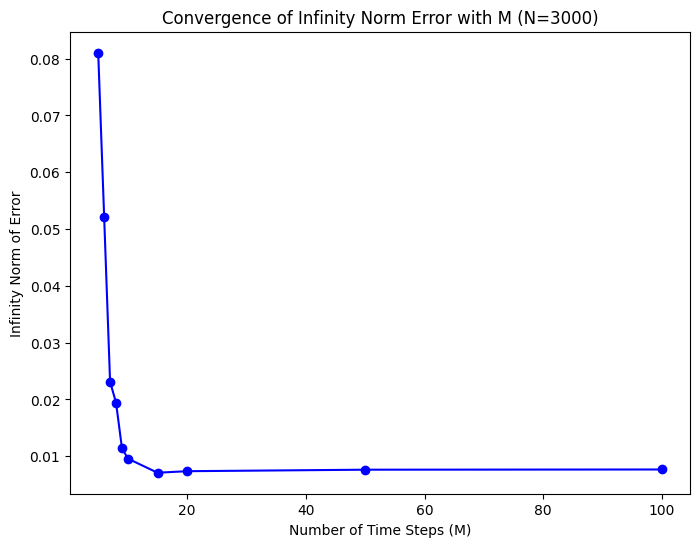

In [132]:
## 1: N fixed, Crank-Nicholson
M=[5,6,7,8,9,10,15,20,50,100]
inf_err = []

for m in M:
    solver_CN = Euro_Call_PDE_Solver(S0=50, K=50, T=1, r=0.05, sigma=0.2,space_factor=10,M=m,N=3000,theta=0.5)
    solver_CN.solve_edp()
    inf_err.append(max(solver_CN.error))
    print(f"{m} is done")
    
# Plot the convergence of the infinity norm error / We used chat gpt here to gain some time and see a better result
plt.figure(figsize=(8, 6))
plt.plot(M, inf_err, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Time Steps (M)')
plt.ylabel('Infinity Norm of Error')
plt.title('Convergence of Infinity Norm Error with M (N=3000)')
plt.show()

50 is done
100 is done
200 is done
500 is done
1000 is done


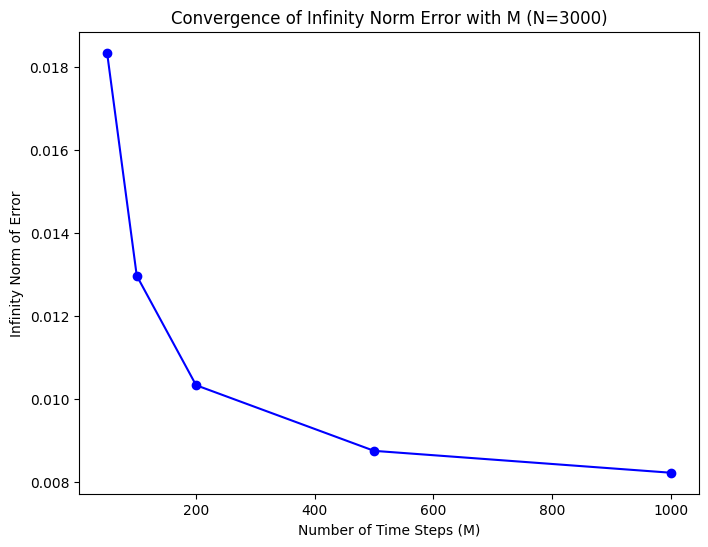

In [133]:
## 1: N fixed, Euler
M=[50,100,200,500,1000]
inf_err = []

for m in M:
    solver_euler = Euro_Call_PDE_Solver(S0=50, K=50, T=1, r=0.05, sigma=0.2,space_factor=10,M=m,N=3000,theta=1)
    solver_euler.solve_edp()
    inf_err.append(max(solver_euler.error))
    print(f"{m} is done")
    
# Plot the convergence of the infinity norm error / We used chat gpt here to gain some time and see a better result
plt.figure(figsize=(8, 6))
plt.plot(M, inf_err, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Time Steps (M)')
plt.ylabel('Infinity Norm of Error')
plt.title('Convergence of Infinity Norm Error with M (N=3000)')
plt.show()

*Comments: We find that the convergence rate of the euler method is of order 1 in time, whereas the convergence rate of the CN method (order 2) is very fast, you only need a few timesteps to price very precisely.*

#### Part 4: General punctual error

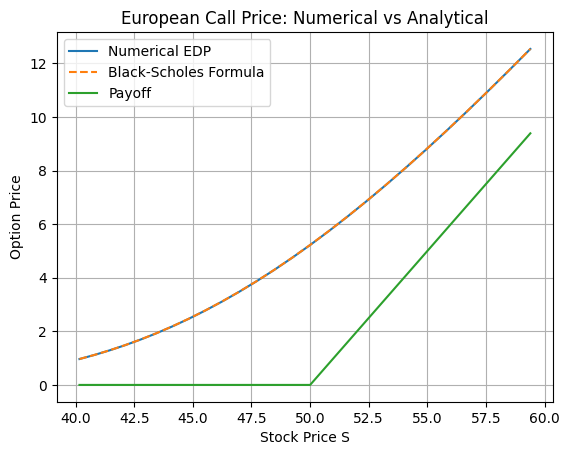

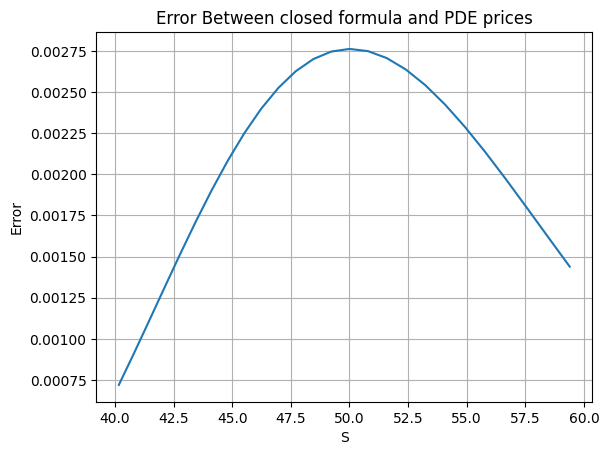

In [150]:
solver_CN = Euro_Call_PDE_Solver(S0=50, K=50, T=1, r=0.05, sigma=0.2, space_factor=10, M=1000, N=5000, theta=0.5)
solver_CN.solve_edp()
solver_CN.plot_results()


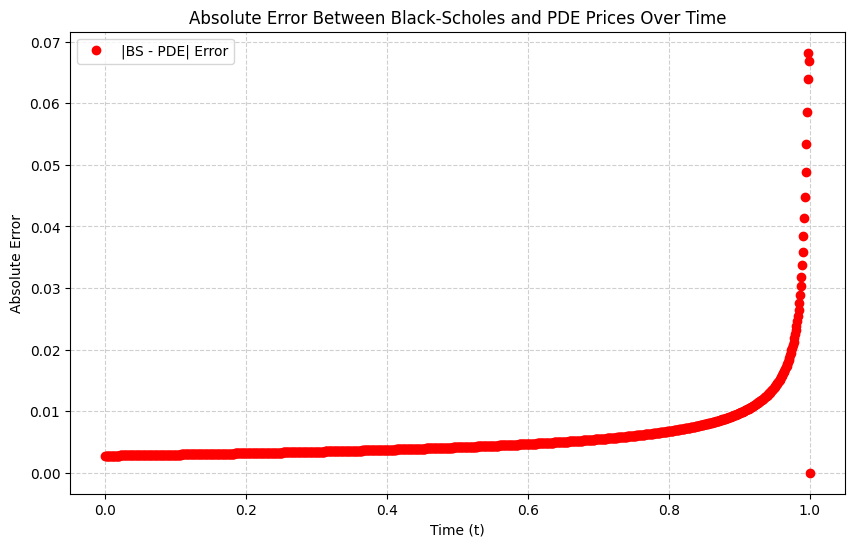

In [154]:
U = solver_CN.U
t = solver_CN.t
T = solver_CN.T
S = solver_CN.K # lets see at the money
y = solver_CN.y

idx = (np.abs(y - np.log(S))).argmin()

BS_prices = [0]*len(t)
BS_prices[1:] = solver_CN.BS_Euro_Call(S,t[1:])

PDE_prices = U[idx,:]
plt.figure(figsize=(10, 6))
plt.plot(t[::-1], np.abs(BS_prices - PDE_prices), marker='o', linestyle='', color='r', label='|BS - PDE| Error')
plt.xlabel('Time (t)')
plt.ylabel('Absolute Error')
plt.title('Absolute Error Between Black-Scholes and PDE Prices Over Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

*Comments: at the expiry date T=1, we have 0 error since both are just (ST-K)+, and then the error decreases when we go to t=0 which is when the product needs to be priced (we are indeed looking at the price of a product expiring in one year, this is why we reverse the t list in the plot for better readability).*